In [101]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import greedy_policy
from tf_agents.policies import ActorPolicy
from tf_agents.networks import value_network
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.ddpg.actor_network import ActorNetwork
from tf_agents.agents.ddpg.critic_network import CriticNetwork
from tf_agents.utils import common
import tempfile, os

import matplotlib.pyplot as plt
import qutip
from qutip import Bloch, QobjEvo, basis, sesolve, sigmay, sigmaz, sigmax, expect

import random

import sys
sys.path.append('../')
from environments.qubit_env import QubitContinuousEnv
from common.common import get_average_return, extract_double_action_policy

%matplotlib inline

* System Parameters

In [102]:
T = 3.5 # terminal time step
max_steps = 30 # number of time steps

fc_layer_params = (100, 75)
replay_buffer_capacity = 100000
nb_episodes = 1
eval_interval = 10
log_interval = 20
batch_size = 100
actor_learning_rate = 1e-2
critic_learning_rate = 1e-2

checkpoint_dir = "../checkpoints/Ddpg_continuous_omega_plus_detuning_qubit/"

nb_iterations = 1000

In [103]:
max_Ω = 1.0
max_Δ = 0.5

environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.99, verbose_fg = False)
eval_environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.99, verbose_fg = False)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

* Actor/Policy network

In [104]:
actor_network = ActorNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy"
)

critic_network = CriticNetwork(
    input_tensor_spec = (train_env.time_step_spec().observation, train_env.action_spec()),
    observation_fc_layer_params= (100, 50),
    #joint_fc_layer_params = (50, 25),
)

# use tha Adam optimizers
actor_optimizer = tf.keras.optimizers.Adam(learning_rate = actor_learning_rate)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate = critic_learning_rate)

train_step_counter = tf.Variable(0)

agent = ddpg_agent.DdpgAgent(
    time_step_spec = environment.time_step_spec(),
    action_spec = environment.action_spec(),
    actor_network = actor_network,
    critic_network = critic_network,
    actor_optimizer = actor_optimizer,
    critic_optimizer = critic_optimizer,
    train_step_counter = train_step_counter,
    gamma = 0.99,
    ou_stddev = 1,
    ou_damping = 1,
    target_update_tau = 0.5,
    gradient_clipping = 1
)

agent.initialize()

In [105]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver

# collect data
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers = [replay_buffer.add_batch],
    num_steps = max_steps
)

# create checkpointer to load training and continue
""" checkpointer = common.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

' checkpointer = common.Checkpointer(\n    ckpt_dir = checkpoint_dir,\n    max_to_keep = 1,\n    agent = agent,\n    policy = agent.policy,\n    replay_buffer = replay_buffer,\n)\n\ncheckpointer.initialize_or_restore() '

In [106]:
avg_returns = []
losses = []

# loop for all iterations
for _ in range(nb_iterations):
    collect_driver.run()

    # get the dataset
    dataset = replay_buffer.as_dataset(
        num_parallel_calls = 3,
        sample_batch_size = batch_size,
        num_steps = 2
    ).prefetch(3)

    iterator = iter(dataset)

    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        losses.append(train_loss)

    if step % eval_interval == 0:
        avg_return = get_average_return(eval_env, agent.policy, 10)
        avg_returns.append(avg_return)

# checkpointer.save(train_step_counter)

step = 20: loss = 0.14353232085704803


KeyboardInterrupt: 

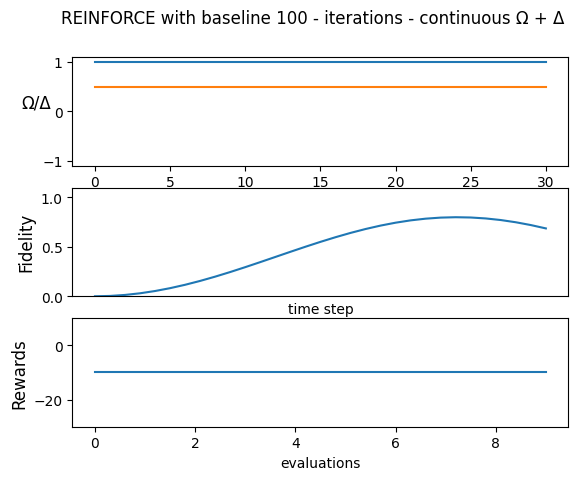

In [ ]:
greedy_actions, [optimal_omegas, optimal_detuning], states, fidelities = extract_double_action_policy(environment, agent)

time_span = np.arange(len(optimal_omegas))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle(f'REINFORCE with baseline {agent.train_step_counter.numpy()} - iterations - continuous Ω + Δ')
ax1.step(time_span, optimal_omegas, where = 'post')
ax1.step(time_span, optimal_detuning, where = 'post')
ax1.set_ylabel("Ω/Δ", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))

time_span2 = range(len(fidelities))
ax2.plot(time_span2, fidelities)
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"time step")
ax2.tick_params(left = True, right = False , labelleft = True, labelbottom = False, bottom = False) 
ax2.set_ylim((0, 1.1))

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Rewards", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
ax3.set_ylim((-30, 10))
plt.show()